Accuracy: 0.8292
ROC AUC: 0.9155

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84       241
           1       0.80      0.84      0.82       204

    accuracy                           0.83       445
   macro avg       0.83      0.83      0.83       445
weighted avg       0.83      0.83      0.83       445


Confusion Matrix:
[[197  44]
 [ 32 172]]


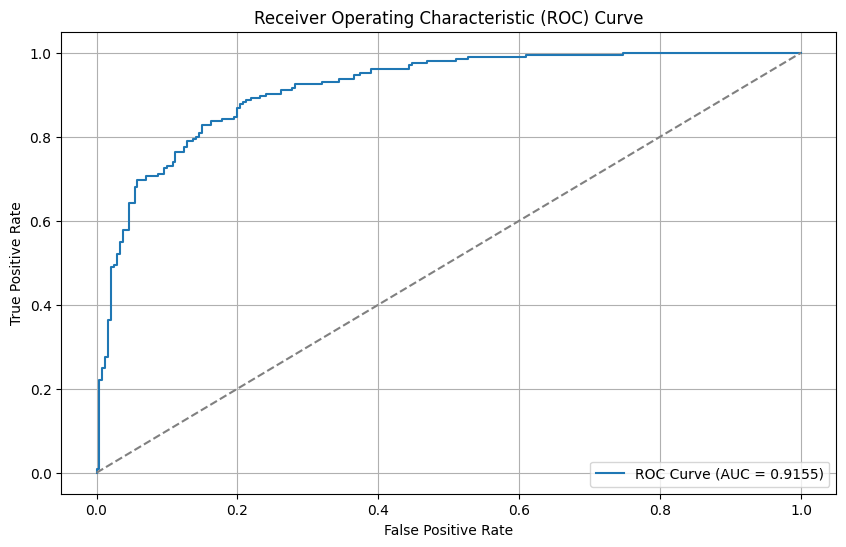

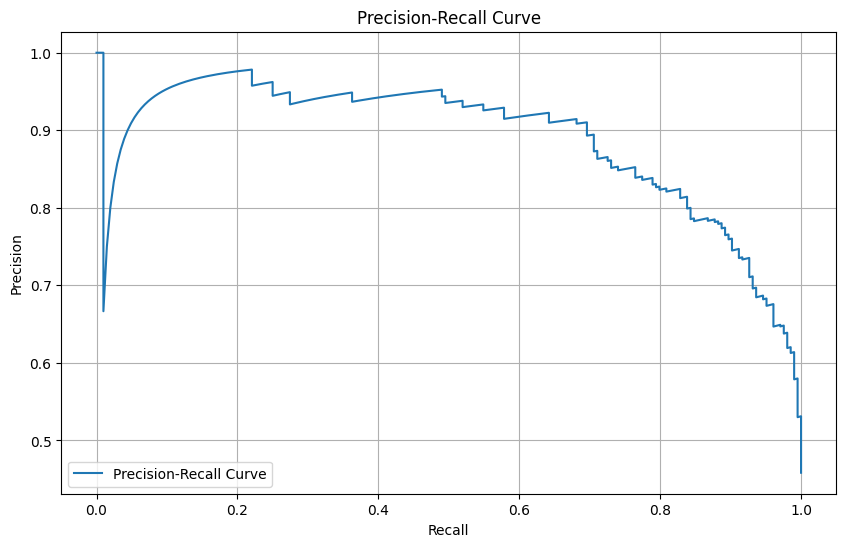

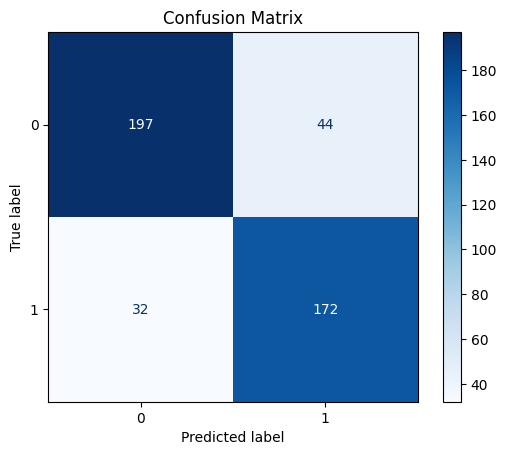

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

# Load dataset
file_path = '/mnt/data/preprocessed_corrected_dataset.csv'
data = pd.read_csv("/content/preprocessed_corrected_dataset.csv")

# Ensure the target column exists
if 'Diagnosis' not in data.columns:
    raise ValueError("Target column 'Diagnosis' not found in the dataset.")

# Split data into features (X) and target (y)
X = data.drop(columns=['Diagnosis'])
y = data['Diagnosis']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train Logistic Regression model
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_rep)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

# Display Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
